<a href="https://colab.research.google.com/github/SangMin316/EEG_Data/blob/main/221027_sepectral_pathway_maxpool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torch.utils.data import Dataset
import torch
import pickle
import mne
import numpy as np
import time

class Sleepedf_dataset(Dataset):
    def __init__(self, files, seq_len, SSL = bool):
        self.files = files
        self.sequence_length = seq_len
        self.SSL = SSL
        # sample을 split해줬을 때 몇개로 split되는지 누적해서 저장, i번째 data를 찾을 때 data_adress 각 값이 기준이 됨
        data_adress = [0]
        ad = 0
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            c,t = sample.shape
            t = int(t/self.sequence_length) 
            ad += t
            data_adress.append(ad)
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
        
        self.data_adress = data_adress
        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 2, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 2, keepdims=True) # shape = b,c
        b,c,t = data.shape
        
        return data/data_max*np.ones((b,c,t)) - (data_max - data_min)*np.ones((b,c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'Sleep stage W':
          y = np.array([1,0,0,0,0])
        elif y == 'Sleep stage 1':
          y = np.array([0,1,0,0,0])
        elif y == 'Sleep stage 2':
          y = np.array([0,0,1,0,0])   
        elif y == 'Sleep stage 3':
          y = np.array([0,0,0,1,0])
        elif y == 'Sleep stage R':
          y = np.array([0,0,0,0,1])      
        return y  


    def __getitem__(self, index):
        for i in range(len(self.data_adress)):
            if index < self.data_adress[i]:
                break
          
        sample = np.load(self.files[i-1])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.split_data(sample['x'])
        sample = self.preprocessing(sample)

        if self.SSL:
          return sample[index - self.data_adress[i-1],:,:]
        else:
          return { 'x' : torch.tensor(sample[index - self.data_adress[i-1],:,:]), 
                   'y' : torch.tensor(y)
                   }

          
          
    def __len__(self):
        return self.data_adress[-1]


In [3]:
class MASS_dataset(Dataset):
    def __init__(self, files, seq_len, SSL = bool):
        self.files = files
        self.sequence_length = seq_len
        self.SSL = SSL
        # self.freq = 1.28 # 256Hz / 1.28 = 200Hz
        # sample을 split해줬을 때 몇개로 split되는지 누적해서 저장, i번째 data를 찾을 때 data_adress 각 값이 기준이 됨
        data_adress = [0]
        ad = 0
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            c,t = sample.shape
            t = int(t/self.sequence_length) 
            ad += t
            data_adress.append(ad)
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
      
        self.data_adress = data_adress
        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 2, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 2, keepdims=True) # shape = b,c
        b,c,t = data.shape
        
        return data/data_max*np.ones((b,c,t)) - (data_max - data_min)*np.ones((b,c,t))/(self.max_value - self.min_value)


    def split_data(self, data):
        L = self.sequence_length
        channels, length = data.shape
        a = L*int(length/L)
        
        if length == a:
            data = np.reshape(data,(int(length/L),channels,L))
        
        else:
            data = data[:,:a]
            data = np.reshape(data,(int(a/L),channels,L))
        return data

    def one_hot_encoding(self,y):
        if y == 'Sleep stage W':
          y = np.array([1,0,0,0,0])
        elif y == 'Sleep stage 1':
          y = np.array([0,1,0,0,0])
        elif y == 'Sleep stage 2':
          y = np.array([0,0,1,0,0])   
        elif y == 'Sleep stage 3':
          y = np.array([0,0,0,1,0])
        elif y == 'Sleep stage R':
          y = np.array([0,0,0,0,1])      
        return y  


    def __getitem__(self, index):
        for i in range(len(self.data_adress)):
            if index < self.data_adress[i]:
                break
          
        sample = np.load(self.files[i-1])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.split_data(sample['x'])
        sample = self.preprocessing(sample)

        if self.SSL:
          return sample[index - self.data_adress[i-1],:,:]
        else:
          return { 'x' : torch.tensor(sample[index - self.data_adress[i-1],:,:]), 
                   'y' : torch.tensor(y)
                   }

          
    def __len__(self):
        return self.data_adress[-1]

In [4]:
from sklearn.model_selection import train_test_split

class concat_dataset():
    def __init__(self, data_dic,seq_len):
        self.data_dic = data_dic #data_dic : {'dataset1_name : [dataset1_adress],,,datasetN_name : [datasetN_adress]}
        self.seq_len = seq_len
    
    def tr_val_te_split(self,data_list):
        train, test = train_test_split(data_list, test_size=0.2)#, shuffle=True, random_state=34), #stratify=target
        train, val = train_test_split(train, test_size= 0.25)#, shuffle=True, random_state=34)
        del data_list
        print('split done')
        return train, val, test    
    
    def call(self):
        # train_dataset = [] # extend로 빈 어레의 받으면 메모리가 터지는 문제 발생했음.
        # val_dataset = []
        # test_dataset = []
    
        for name, data_list in self.data_dic.items():
            print(name)
            tr, val, te = self.tr_val_te_split(data_list)
            
            if name =='Sleep_edf':
                sleepedf_train_data = Sleepedf_dataset(tr,self.seq_len,SSL = True)
                print('sleep train done')
                sleepedf_val_data = Sleepedf_dataset(val,self.seq_len, SSL = True)
                print('sleep val done')
                sleepedf_test_data = Sleepedf_dataset(te,self.seq_len, SSL = True)
                print('sleep test done')
            
            elif name == 'MASS':
                MASS_train_data = Sleepedf_dataset(tr,self.seq_len, SSL = True)
                print('MASS train done')
                MASS_val_data = Sleepedf_dataset(val,self.seq_len, SSL = True)
                print('MASS val done')
                MASS_test_data = Sleepedf_dataset(te,self.seq_len, SSL = True)
                print('MASS test done')
        
            # train_dataset.extend(train_data)
            # val_dataset.extend(val_data)
            # test_dataset.extend(test_data)
            # print(train_data)

        # del train_data,val_data, test_data
    
        train_dataset = torch.utils.data.ConcatDataset([sleepedf_train_data,MASS_train_data])
        val_dataset = torch.utils.data.ConcatDataset([sleepedf_test_data,MASS_val_data])
        test_dataset = torch.utils.data.ConcatDataset([sleepedf_val_data,MASS_test_data])
    
        return train_dataset, val_dataset, test_dataset

In [5]:
import glob
SC_list = glob.glob('/content/drive/MyDrive/sleep_edfx/Preprocessed_EEG/SC/**')
print(len(SC_list))
sleepedf_list = []
for i in range(2):
  length = len(sleepedf_list)
  sleepedf_list.extend(glob.glob(SC_list[i]+'/**'))
  print(len(sleepedf_list) - length)
len(sleepedf_list)

153
2650
2830


5480

In [6]:
SS1_list = glob.glob('/content/drive/MyDrive/EEG_data/MASS/SS1/Preprocessed_EEGedf/**')
print(len(SS1_list))
MASS_list = []
for i in range(7,14):
    length = len(MASS_list)
    MASS_list.extend(glob.glob(SS1_list[i]+'/**'))
    print(len(MASS_list) - length)
print(len(MASS_list))

53
1004
1071
937
1041
1079
991
877
7000


In [7]:
data_dic = {'MASS' : MASS_list[:1000], 'Sleep_edf': sleepedf_list[:1000]}

In [8]:
train_dataset, val_dataset, test_dataset = concat_dataset(data_dic, seq_len = 200).call()

MASS
split done
MASS train done
MASS val done
MASS test done
Sleep_edf
split done
sleep train done
sleep val done
sleep test done


In [9]:
from torch.utils.data import DataLoader
trainLoader = DataLoader(train_dataset, batch_size = 10 , shuffle= False)
valLoader = DataLoader(val_dataset, batch_size = 10 , shuffle= False)
testLoader = DataLoader(test_dataset, batch_size = 10 , shuffle= False)


In [10]:
import time
start_T = time.time()
for batch_idx, batch in enumerate(valLoader):
  print('batch_idx:',batch_idx,' ',batch.shape)
  end_T = time.time()
  print('time:', end_T - start_T)
  if batch_idx >= 10:
        break

batch_idx: 0   torch.Size([10, 2, 200])
time: 0.029386520385742188
batch_idx: 1   torch.Size([10, 2, 200])
time: 0.05707073211669922
batch_idx: 2   torch.Size([10, 2, 200])
time: 0.10046577453613281
batch_idx: 3   torch.Size([10, 2, 200])
time: 0.12891316413879395
batch_idx: 4   torch.Size([10, 2, 200])
time: 0.16936659812927246
batch_idx: 5   torch.Size([10, 2, 200])
time: 0.20062780380249023
batch_idx: 6   torch.Size([10, 2, 200])
time: 0.2271122932434082
batch_idx: 7   torch.Size([10, 2, 200])
time: 0.2703359127044678
batch_idx: 8   torch.Size([10, 2, 200])
time: 0.2999448776245117
batch_idx: 9   torch.Size([10, 2, 200])
time: 0.35770487785339355
batch_idx: 10   torch.Size([10, 2, 200])
time: 0.3987867832183838


In [11]:
!pip install separableconv-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import numpy as np
import torch
import torch.nn as nn
from mne.filter import filter_data, notch_filter
import matplotlib.pyplot as plt
# import hypertools as hyp
from sklearn.metrics import f1_score



class StoppedBandPredTaskLoss(torch.nn.modules.loss._Loss):
    def __init__(self, bands, labels, device):
        super().__init__()
        self.device = device
        self.BAND = bands
        self.LABEL = labels

    def forward(self, batch, encoder, sfreq, train):
        batch_aug = []
        batch_label = []
        b,c,t = batch.shape
        batch = np.reshape(batch,(c,b*t))        #Band has freqeuncy range, filter_data plays the role of Band Stop filter
        
        #each Labels are composed of one-hot vectors and are copied ( Bands size * Batch size )
        for idx,band in enumerate(self.BAND):
            lfreq, rfreq = band
            data = filter_data(batch.numpy().astype(np.float64), sfreq=sfreq, l_freq=rfreq, h_freq=lfreq, verbose=False)
            batch_aug.extend(data)
            batch_label.extend((data.shape[0]*b) * [self.LABEL[idx]])

        #[batch, augmentation, channel, time length] -> [batch*augmentation, channel, time length]
        # b,a,l = np.array(batch_aug).shape
        batch_aug = np.array(batch_aug)
 
        batch_label = np.array(batch_label)
        batch_aug = np.reshape(batch_aug,(5*c*b,1,t))
        batch_label = torch.Tensor(batch_label).to(device)
  
        #Self-supervised Learning Loss is CrossEntropy
        CrossEL = torch.nn.CrossEntropyLoss()
        pred = encoder.forward(torch.Tensor(batch_aug).to(device))
        loss = CrossEL(pred, batch_label)
        _, y =  torch.max(batch_label, 1) 
        _, predicted = torch.max(pred, 1) 
        
    
        if train:
            loss.backward(retain_graph=True)
            
        acc = (predicted == y).sum().item()
        acc = acc/len(predicted) #acc/(batch*channels*5(augmented))
        loss = loss
      
        del y
        return loss, acc

In [13]:
def weight_init_xavier_uniform(submodule):
    # if isinstance(submodule, snn.SeparableConv1d):
    #     torch.nn.init.xavier_uniform_(submodule.weight)

    if isinstance(submodule, nn.Linear):
        torch.nn.init.xavier_uniform_(submodule.weight)

class Encoder(nn.Module):
    def __init__(self, fs, encode_info):
        super(Encoder, self).__init__()
        #spectral layer means spectral convolution
        #self.bac_layer is consist of several SeparableConv2d, which plays the role of temporal separable convolution
        #convolution layer are initiated by xavier_uniform initization
        #Input are Normalized by self.bn(=torch.nn.BatchNorm2d)
        #[batch, electrode, length] -> [batch, electrode, Feature]
        self.fs = fs
        self.elu = nn.ELU()
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.bn = nn.BatchNorm1d(1)
        self.activation = nn.LeakyReLU()

        self.spectral_layer = nn.Conv1d(1, 10, int(self.fs/2), padding="same")

        # self.bac_layer = nn.Sequential()
        # for i, arg in enumerate(encode_info):
        #     input_dim, output_dim, kernel_size = arg
        #     self.bac_layer.add_module("temporal_conv_"+str(i),
        #                           nn.Conv1d(input_dim, output_dim, kernel_size, padding = 'same'))
        #     self.bac_layer.add_module("ELU",nn.ELU()) 
        
        self.conv1t = nn.Conv1d(10,16, 30, padding ='same')
        self.conv2t = nn.Conv1d(16,32, 15, padding ='same')
        self.conv3t = nn.Conv1d(32,64, 5, padding ='same')
        
        torch.nn.init.xavier_uniform_(self.spectral_layer.weight)
        #self.bac_layer.apply(weight_init_xavier_uniform)

    def forward(self, x):
        x = self.activation(self.spectral_layer(x))
        x = self.activation(self.conv1t(x))
        x = self.activation(self.conv2t(x))
        x = self.activation(self.conv3t(x))

        return x

#Linear layer for SSL classification
class Head_NN(nn.Module):
    def __init__(self):
        super(Head_NN, self).__init__()
        self.length = length
        
        # self.layer = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(64*length, 5)
        # )
        
        self.layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 5)
        )
        
        self.softmax = torch.nn.Softmax()
        # self.layer.apply(weight_init_xavier_uniform)
        self.bn = nn.BatchNorm1d(64)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = torch.mean(x, axis = 2) # Global average pooling into temporal dimension
        # x = self.flatten(x)
        x = self.layer(x)
        x = self.softmax(x)
        return x

class StoppedBandPathway(nn.Module):
    def __init__(self, fs, Unsupervise, encode_info, bands):
        super(StoppedBandPathway, self).__init__()
        self.encoder = Encoder(fs, encode_info)
        self.pretrain = Head_NN()
        self.Unsupervise = Unsupervise


    def forward(self, x):
        x = self.encoder(x)
        x = self.pretrain(x)
        return x

    def getRep(self, x):
        x = self.encoder(x)
        return x


In [14]:
import os
import torch
# batch size
batch_size = 250
learning_rate = 0.001
epochs = 20

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"

In [15]:
print(device)

cuda:0


In [16]:
from torch.utils.data import DataLoader
trainLoader = DataLoader(train_dataset, batch_size = batch_size , shuffle= False)
valLoader = DataLoader(val_dataset, batch_size = batch_size , shuffle= False)
testLoader = DataLoader(test_dataset, batch_size = batch_size , shuffle= False)

In [17]:
BANDS = [(0.5,4), (4,8), (8,15), (15,30), (30,49.9)]
LABEL = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]]

encode_info = [(10, 16, 30),(16, 32, 15),(32, 64, 5)]
sfreq = 200


model = StoppedBandPathway(sfreq,True,encode_info,BANDS).to(device)
#model = MSNN.feature_extractor3(sfreq).to(device)

# Custom Tripletloss
criterion = StoppedBandPredTaskLoss(BANDS, LABEL, device=device)


# use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [18]:
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []

for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    #concatdata.getTrain()
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        # print(batch.shape)
        loss_batch, acc_batch = criterion.forward(batch, model, sfreq, train = True)
        optimizer.step()
        loss_ep += loss_batch.item()
        acc_ep += acc_batch
        # print('acc',acc_batch)
        # print('loss:',loss_batch.item())
    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))

    loss_ep_val = 0
    acc_ep_val = 0

    with torch.no_grad():
        loss_v = 0
        acc_v = 0
        #concatdata.getVal()
        for batch_idx, batch in enumerate(valLoader):
            loss_batch, acc_batch = criterion.forward(batch, model, sfreq, train = False)
            loss_ep_val += loss_batch.item()
            acc_ep_val += acc_batch
    
        loss_val.append((loss_ep_val)/len(valLoader))
        acc_val.append((acc_ep_val)/len(valLoader))
        print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])  
        torch.save(model,'Spectral__1s_ep' + str(epoch)+'_.pt')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch :  0   train loss :  1.5185537810126941 train acc :  0.3351114197530862     val loss :  1.4843077237407367 val acc :  0.37049629629629627
epoch :  1   train loss :  1.4552071657445695 train acc :  0.4109166666666669     val loss :  1.4046974256634712 val acc :  0.46342407407407404
epoch :  2   train loss :  1.393648503555192 train acc :  0.47490462962962976     val loss :  1.3833962405721347 val acc :  0.485012037037037
epoch :  3   train loss :  1.37932507859336 train acc :  0.4912527777777778     val loss :  1.374220351378123 val acc :  0.4977703703703702
epoch :  4   train loss :  1.3712338382999103 train acc :  0.5073845679012344     val loss :  1.3619458998243015 val acc :  0.5223620370370371
epoch :  5   train loss :  1.3263233775893848 train acc :  0.5637966049382714     val loss :  1.3048171723882358 val acc :  0.5819564814814814
epoch :  6   train loss :  1.2744668639368482 train acc :  0.6141765432098768     val loss :  1.2635038544734318 val acc :  0.6235435185185184
e

result save and plot

In [19]:
import pandas as pd
col = ['loss_tr','loss_val','acc_tr','acc_val']
data = np.array([loss_tr,
                 loss_val,
                 acc_tr,
                 acc_val])
print(data.shape)
data = np.transpose(data)
df = pd.DataFrame(data = data, columns= col)
df.to_excel('s_Sleepedf+MASS_1s.xlsx', index = False)

(4, 20)


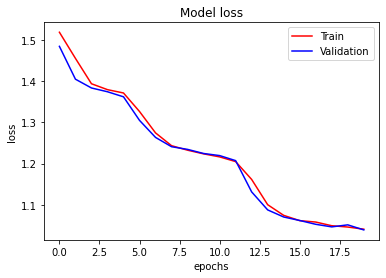

In [20]:
# plt.figure(figsize =(15, 10))

plt.plot(range(epochs), loss_tr, color='red')
plt.plot(range(epochs), loss_val, color='blue')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('s_Sleepedf+MASS_loss_1s',bbox_inches = 'tight')
plt.show()


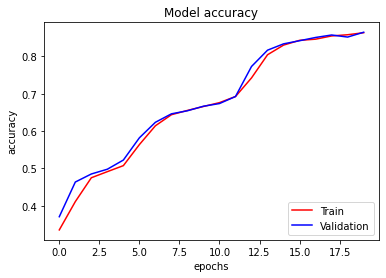

In [21]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), acc_tr, color='red')
plt.plot(range(epochs), acc_val, color='blue')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('s_Sleepedf+MASS_accuracy_5s',bbox_inches = 'tight')
plt.show()

In [22]:
torch.cuda.empty_cache() # GPU 캐시 데이터 삭제

In [27]:
model = torch.load('/content/Spectral__1s_ep19_.pt')
model.to(device)

StoppedBandPathway(
  (encoder): Encoder(
    (elu): ELU(alpha=1.0)
    (maxpool): AdaptiveMaxPool1d(output_size=1)
    (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.01)
    (spectral_layer): Conv1d(1, 10, kernel_size=(100,), stride=(1,), padding=same)
    (conv1t): Conv1d(10, 16, kernel_size=(30,), stride=(1,), padding=same)
    (conv2t): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=same)
    (conv3t): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
  )
  (pretrain): Head_NN(
    (layer): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=64, out_features=5, bias=True)
    )
    (softmax): Softmax(dim=None)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
)

In [28]:
loss_test = 0
acc_test = 0
for batch_idx, batch in enumerate(testLoader):
  loss_batch, acc_batch = criterion.forward(batch, model, sfreq, train = False)
  loss_test += loss_batch.item()
  acc_test += acc_batch


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [29]:
print('loss:',loss_test/len(testLoader))
print('acc:',acc_test/len(testLoader))

loss: 1.0386339177687962
acc: 0.8655749999999999
